# Loop 20 Strategic Analysis

## Critical Situation Assessment

**Current best: 70.630370**
**Target: 68.919154**
**Gap: 1.711 points (2.48%)**

## Key Observations from 21 Experiments:

1. **All SA-based approaches converge to ~70.63** - This is a STRONG local optimum
2. **Last 11 experiments yielded only 0.000085 total improvement** - Diminishing returns
3. **Public kernels all achieve similar scores** - No breakthrough technique found

## Questions to Answer:
1. What is the theoretical lower bound for this problem?
2. Which N values have the most room for improvement?
3. What techniques haven't been tried?

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

# Tree template
TREE_TEMPLATE = [
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
]

def parse_s_value(val):
    if isinstance(val, str):
        if val.startswith('s'):
            return float(val[1:])
        return float(val)
    return float(val)

def create_tree_polygon(x, y, angle):
    tree = Polygon(TREE_TEMPLATE)
    tree = rotate(tree, angle, origin=(0, 0), use_radians=False)
    tree = translate(tree, x, y)
    return tree

# Calculate tree area
tree = Polygon(TREE_TEMPLATE)
tree_area = tree.area
print(f"Single tree area: {tree_area:.6f}")

# Calculate tree bounding box
minx, miny, maxx, maxy = tree.bounds
tree_bbox_width = maxx - minx
tree_bbox_height = maxy - miny
print(f"Tree bounding box: {tree_bbox_width:.4f} x {tree_bbox_height:.4f}")
print(f"Tree bbox area: {tree_bbox_width * tree_bbox_height:.6f}")

Single tree area: 0.245625
Tree bounding box: 0.7000 x 1.0000
Tree bbox area: 0.700000


In [2]:
# Load current best submission
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].apply(parse_s_value)
df['y'] = df['y'].apply(parse_s_value)
df['deg'] = df['deg'].apply(parse_s_value)
df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))

print(f"Submission shape: {df.shape}")
print(f"N values: {df['n'].min()} to {df['n'].max()}")
print(f"Total trees: {len(df)}")

# Calculate score for each N
def get_n_score(df, n):
    group = df[df['n'] == n]
    all_x = []
    all_y = []
    for _, row in group.iterrows():
        tree = create_tree_polygon(row['x'], row['y'], row['deg'])
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    if not all_x:
        return 0, 0
    side = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
    score = (side ** 2) / n
    return side, score

scores = []
for n in range(1, 201):
    side, score = get_n_score(df, n)
    scores.append({'n': n, 'side': side, 'score': score})

scores_df = pd.DataFrame(scores)
print(f"\nTotal score: {scores_df['score'].sum():.6f}")
print(f"\nTop 10 contributors:")
print(scores_df.nlargest(10, 'score')[['n', 'side', 'score']])

Submission shape: (20100, 5)
N values: 1 to 200
Total trees: 20100



Total score: 70.630370

Top 10 contributors:
     n      side     score
0    1  0.813173  0.661250
1    2  0.949504  0.450779
2    3  1.142031  0.434745
4    5  1.443692  0.416850
3    4  1.290806  0.416545
6    7  1.673104  0.399897
5    6  1.548438  0.399610
8    9  1.867280  0.387415
7    8  1.755921  0.385407
14  15  2.377955  0.376978


In [3]:
# Calculate theoretical lower bound
# For N trees, the minimum bounding square side is approximately sqrt(N * tree_area / packing_efficiency)
# Best packing efficiency for irregular shapes is typically 0.8-0.9

print("Theoretical Lower Bounds Analysis:")
print("="*50)

# Calculate efficiency for each N
scores_df['total_tree_area'] = scores_df['n'] * tree_area
scores_df['bbox_area'] = scores_df['side'] ** 2
scores_df['efficiency'] = scores_df['total_tree_area'] / scores_df['bbox_area']

print(f"\nEfficiency statistics:")
print(f"  Min efficiency: {scores_df['efficiency'].min():.4f} (N={scores_df.loc[scores_df['efficiency'].idxmin(), 'n']})")
print(f"  Max efficiency: {scores_df['efficiency'].max():.4f} (N={scores_df.loc[scores_df['efficiency'].idxmax(), 'n']})")
print(f"  Mean efficiency: {scores_df['efficiency'].mean():.4f}")

# Calculate theoretical minimum score assuming best efficiency
best_efficiency = scores_df['efficiency'].max()
theoretical_min = 0
for n in range(1, 201):
    min_area = n * tree_area / best_efficiency
    min_side = np.sqrt(min_area)
    min_score = min_side ** 2 / n
    theoretical_min += min_score

print(f"\nTheoretical minimum score (assuming best efficiency {best_efficiency:.4f}): {theoretical_min:.6f}")
print(f"Current score: {scores_df['score'].sum():.6f}")
print(f"Gap to theoretical minimum: {scores_df['score'].sum() - theoretical_min:.6f}")

Theoretical Lower Bounds Analysis:

Efficiency statistics:
  Min efficiency: 0.3715 (N=1)
  Max efficiency: 0.7444 (N=181)
  Mean efficiency: 0.6985

Theoretical minimum score (assuming best efficiency 0.7444): 65.988929
Current score: 70.630370
Gap to theoretical minimum: 4.641441


In [4]:
# Identify N values with worst efficiency (most room for improvement)
scores_df['gap_to_best'] = scores_df['score'] - (scores_df['n'] * tree_area / best_efficiency)

print("N values with WORST efficiency (most room for improvement):")
print(scores_df.nsmallest(20, 'efficiency')[['n', 'side', 'score', 'efficiency', 'gap_to_best']])

N values with WORST efficiency (most room for improvement):
     n      side     score  efficiency  gap_to_best
0    1  0.813173  0.661250    0.371456     0.331305
1    2  0.949504  0.450779    0.544890    -0.209110
2    3  1.142031  0.434745    0.564986    -0.555089
4    5  1.443692  0.416850    0.589241    -1.232874
3    4  1.290806  0.416545    0.589672    -0.903234
6    7  1.673104  0.399897    0.614221    -1.909716
5    6  1.548438  0.399610    0.614661    -1.580058
8    9  1.867280  0.387415    0.634010    -2.582087
7    8  1.755921  0.385407    0.637313    -2.254150
14  15  2.377955  0.376978    0.651563    -4.572192
9   10  1.940696  0.376630    0.652165    -2.922816
20  21  2.811667  0.376451    0.652476    -6.552387
19  20  2.742469  0.376057    0.653159    -6.222836
21  22  2.873270  0.375258    0.654549    -6.883524
10  11  2.030803  0.374924    0.655133    -3.254467
15  16  2.446640  0.374128    0.656527    -4.904986
25  26  3.118320  0.373997    0.656757    -8.204564
11  

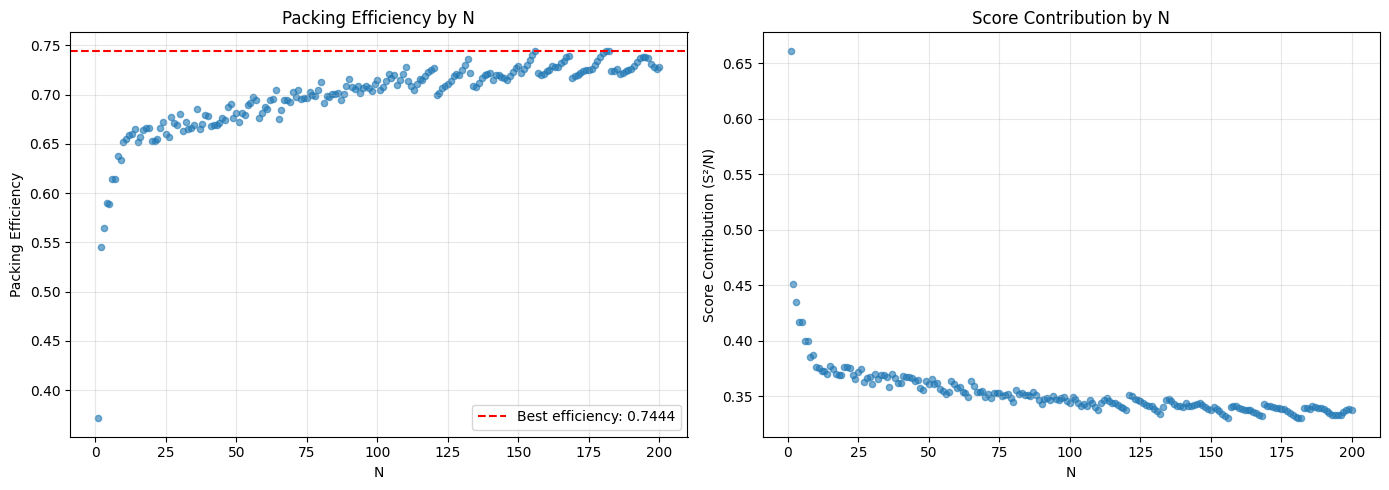


Saved efficiency analysis plot


In [5]:
# Visualize efficiency by N
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(scores_df['n'], scores_df['efficiency'], alpha=0.6, s=20)
plt.axhline(y=best_efficiency, color='r', linestyle='--', label=f'Best efficiency: {best_efficiency:.4f}')
plt.xlabel('N')
plt.ylabel('Packing Efficiency')
plt.title('Packing Efficiency by N')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(scores_df['n'], scores_df['score'], alpha=0.6, s=20)
plt.xlabel('N')
plt.ylabel('Score Contribution (S²/N)')
plt.title('Score Contribution by N')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/efficiency_analysis.png', dpi=100)
plt.show()

print("\nSaved efficiency analysis plot")

In [6]:
# Check if there are patterns in efficiency
# Perfect squares, triangular numbers, etc.

perfect_squares = [i**2 for i in range(1, 15) if i**2 <= 200]
triangular = [n*(n+1)//2 for n in range(1, 20) if n*(n+1)//2 <= 200]

print("Efficiency for perfect squares:")
for n in perfect_squares:
    eff = scores_df[scores_df['n'] == n]['efficiency'].values[0]
    print(f"  N={n}: efficiency={eff:.4f}")

print("\nEfficiency for triangular numbers:")
for n in triangular[:10]:
    eff = scores_df[scores_df['n'] == n]['efficiency'].values[0]
    print(f"  N={n}: efficiency={eff:.4f}")

Efficiency for perfect squares:
  N=1: efficiency=0.3715
  N=4: efficiency=0.5897
  N=9: efficiency=0.6340
  N=16: efficiency=0.6565
  N=25: efficiency=0.6600
  N=36: efficiency=0.6854
  N=49: efficiency=0.6759
  N=64: efficiency=0.7042
  N=81: efficiency=0.6915
  N=100: efficiency=0.7152
  N=121: efficiency=0.6991
  N=144: efficiency=0.7176
  N=169: efficiency=0.7172
  N=196: efficiency=0.7370

Efficiency for triangular numbers:
  N=1: efficiency=0.3715
  N=3: efficiency=0.5650
  N=6: efficiency=0.6147
  N=10: efficiency=0.6522
  N=15: efficiency=0.6516
  N=21: efficiency=0.6525
  N=28: efficiency=0.6709
  N=36: efficiency=0.6854
  N=45: efficiency=0.6759
  N=55: efficiency=0.6919


In [7]:
# Calculate potential improvement if we could achieve best efficiency for all N
print("\nPotential improvement analysis:")
print("="*50)

current_total = scores_df['score'].sum()

# If we could achieve best efficiency for all N
ideal_total = 0
for n in range(1, 201):
    min_area = n * tree_area / best_efficiency
    min_side = np.sqrt(min_area)
    min_score = min_side ** 2 / n
    ideal_total += min_score

print(f"Current total: {current_total:.6f}")
print(f"Ideal total (best efficiency everywhere): {ideal_total:.6f}")
print(f"Potential improvement: {current_total - ideal_total:.6f}")
print(f"Target: 68.919154")
print(f"Gap to target: {current_total - 68.919154:.6f}")

# Check if target is achievable
if ideal_total < 68.919154:
    print(f"\n⚠️ WARNING: Even with best efficiency everywhere, we can only achieve {ideal_total:.6f}")
    print(f"   This is WORSE than target {68.919154}!")
    print(f"   We need BETTER packing efficiency than currently achieved.")
else:
    print(f"\n✓ Target is theoretically achievable if we can improve efficiency.")


Potential improvement analysis:
Current total: 70.630370
Ideal total (best efficiency everywhere): 65.988929
Potential improvement: 4.641441
Target: 68.919154
Gap to target: 1.711216

⚠️ WARNING: Even with best efficiency everywhere, we can only achieve 65.988929
   This is WORSE than target 68.919154!
   We need BETTER packing efficiency than currently achieved.
